## Importing Libraries

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics


# from sklearn.naive_bayes import GaussianNB # not sure if i will be using naive bayes - guaseian
# from sklearn.linear_model import LogisticRegression #not sure if I will be using this either
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score # will use?


%matplotlib inline

## Read In Data

In [2]:
# read in all the corpus
df = pd.read_csv('/Users/adriancampos/Downloads/enron_emails_all.csv')
print(df.shape)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(517401, 52)


In [3]:
df = df.sample(frac=.2)

In [4]:
df.shape

(103480, 52)

In [6]:
# df.to_csv('./data/enron_email_20_percent.csv', index=False)

In [2]:
df = pd.read_csv('./data/enron_email_20_percent.csv')

In [3]:
df.shape

(103480, 52)

## Cleaning Data

In [193]:
# show 55 columns and rows to see my column data

pd.set_option('display.max_columns', 55)
pd.set_option('display.max_rows', 55)

In [5]:
df.head(1)

,Unnamed: 0,Message-ID,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,Cat_1_level_1,Cat_1_level_2,Cat_1_weight,Cat_2_level_1,Cat_2_level_2,Cat_2_weight,Cat_3_level_1,Cat_3_level_2,Cat_3_weight,Cat_4_level_1,Cat_4_level_2,Cat_4_weight,Cat_5_level_1,Cat_5_level_2,Cat_5_weight,Cat_6_level_1,Cat_6_level_2,Cat_6_weight,Cat_7_level_1,Cat_7_level_2,Cat_7_weight,Cat_8_level_1,Cat_8_level_2,Cat_8_weight,Cat_9_level_1,Cat_9_level_2,Cat_9_weight,Cat_10_level_1,Cat_10_level_2,Cat_10_weight,Cat_11_level_1,Cat_11_level_2,Cat_11_weight,Cat_12_level_1,Cat_12_level_2,Cat_12_weight,labeled
0,403470,<117238.1075846810566.JavaMail.evans@thyme>,2000-12-11 09:22:00,frozenset({'susan.scott@enron.com'}),frozenset({'alicia.perkins@enron.com'}),Re: Travel,Susan M Scott,Alicia Perkins,katyhester@hotmail.com,NaN,\Susan_Scott_Dec2000_June2001_2\Notes Folders\...,SCOTT-S,sscott5.nsf,"Hey Alicia, Katy's email address is katyhester...",scott-s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [6]:
# I would like to keep my date, potentially using it as part of my presentation later 
# Keeping that, but converting that as datetime dtype

df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Unnamed: 0                 int64
Message-ID                object
Date              datetime64[ns]
From                      object
To                        object
Subject                   object
X-From                    object
                       ...      
Cat_11_level_1           float64
Cat_11_level_2           float64
Cat_11_weight            float64
Cat_12_level_1           float64
Cat_12_level_2           float64
Cat_12_weight            float64
labeled                     bool
Length: 52, dtype: object

In [7]:
# Dropping all rows that don't think I will be using
# df = df[['Date', 'Subject', 'content', 'X-From', 'X-To']]
df = df[['Date', 'content']]

In [8]:
# sorting df by Date
df = df.sort_values(by='Date')

In [9]:
# Reseting index after sort by date
df = df.reset_index(drop=True)

In [10]:
# Confirming reset
df.head(3)

,Date,content
0,1980-01-01,Outstanding issues (created by Mary Hain/HOU/E...
1,1980-01-01,GRS ElectricGasOil Alert (5-25-99): FERC Annua...
2,1980-01-01,Please sign me up for the Enron Center Garage.


In [11]:
# Checking nulls in content
df.loc[df['content'].notnull()]

,Date,content
0,1980-01-01 00:00:00,Outstanding issues (created by Mary Hain/HOU/E...
1,1980-01-01 00:00:00,GRS ElectricGasOil Alert (5-25-99): FERC Annua...
2,1980-01-01 00:00:00,Please sign me up for the Enron Center Garage.
3,1980-01-01 00:00:00,"Hi Brian, Here are my observations/questions: ..."
4,1980-01-01 00:00:00,Ed & Tracy - Jennifer Shipos is a gas trader o...
5,1980-01-01 00:00:00,Thank you for signing up with eThink. You may ...
6,1980-01-01 00:00:00,A couple of us have been discussing having a s...
...,...,...
103473,2004-02-04 02:14:47,$ * $ * $ * $ * HOTWEBCASH * $ * $ * $ * $ Fin...
103474,2004-02-04 02:14:47,$ * $ * $ * $ * HOTWEBCASH * $ * $ * $ * $ You...


In [12]:
# Removing nulls in content column
df = df.loc[df['content'].notnull()]

In [13]:
# Confirming drop of nulls
df.loc[df['content'].notnull()].shape


(103246, 2)

In [14]:
# Confirming drop of nulls
df.isnull().sum()

Date       0
content    0
dtype: int64

In [15]:
df = df.reset_index(drop=True)

In [16]:
df.shape

(103246, 2)

##  Countvectorize

In [156]:
stopwords = ENGLISH_STOP_WORDS
my_stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient', 'sent', 'enron', 'cc', 'subject',\
                                         'forwarded', 'corp', 'said', 'attached', 'ect',\
                                         'recipient', 'email', 'original', 'doc', 'pm', 'mail', 'message', 'new'\
                                         'enronxgate', 'na', 'year'])


# tf = TfidfVectorizer(analyzer='word', stop_words=my_stopwords, min_df=2, max_df=0.5)
cv = CountVectorizer(analyzer='word', stop_words=my_stopwords, max_features=2000)

# vectorizer = TfidfVectorizer(stop_words='english')
X = cv.fit_transform(df['content']) # this is my sparce matrix



In [157]:
# Additional EDA on number only data that I don't believe is mission critical
pd.set_option('display.max_columns', 500)

In [158]:
# New DataFrame created to remove vectorized numbers
X_df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names()) # this is my dense matrix

In [159]:
# Looking at shape of new dataframe
X_df.shape

(103246, 2000)

In [160]:
X_df.head(1)

,00,000,00pm,01,018,02,03,04,05,06,07,08,09,0f,10,100,11,12,13,14,1400,15,150,16,17,18,19,1996,1998,1999,1st,20,200,2000,2001,2002,202,21,212,22,23,24,25,250,26,27,28,281,29,2a04,2nd,30,300,31,32,33,34,345,3490,35,36,37,38,39,3d,40,400,41,415,42,43,44,45,46,47,48,49,50,500,51,52,53,54,55,56,57,58,59,60,600,646,65,70,713,75,75pt,77002,80,800,853,888,90,95,97,98,99,ability,able,accept,access,according,account,accounting,accounts,acquisition,act,action,actions,active,activities,activity,actual,actually,adams,add,added,addition,additional,address,addressed,administration,administrative,advance,advantage,advice,advise,aep,affairs,affiliate,affiliates,afternoon,agency,agenda,agent,ago,agree,agreed,agreement,agreements,ahead,air,airlines,airport,al,alan,alert,alias,align,allen,allow,allowed,alternative,amendment,america,american,amy,analysis,analyst,analysts,ancillary,andersen,anderson,andrea,andrew,andy,angeles,ann,announce,announced,announcement,annual,answer,aol,ap,appear,appears,applicable,application,applications,apply,appreciate,approach,appropriate,approval,approve,approved,approximately,april,area,areas,arial,arnold,article,asap,ask,asked,asking,assembly,asset,assets,assignment,assist,assistance,assistant,associate,associated,associates,association,assume,attachment,attachments,attempting,attend,attention,attorney,auction,august,austin,authority,authorized,availability,available,average,avoid,awarded,aware,away,azurix,backout,bad,balance,bandwidth,bank,bankruptcy,banks,barbara,barry,base,based,basis,...,strong,structure,students,study,stuff,style,submit,submitted,subscribe,subscription,success,successful,sue,suggest,suggested,suggestions,suite,summary,summer,sun,sunday,suppliers,supplies,supply,support,sure,survey,susan,suzanne,swap,swaps,symes,systems,table,taken,takes,taking,talk,talked,talking,talks,tamara,tana,tanya,target,tariff,task,tax,taxes,taylor,td,td2,te,team,teams,tech,technical,technologies,technology,ted,tel,telephone,tell,term,termination,terms,test,testing,texas,text,th,thank,thanks,thing,things,think,thinking,thomas,thompson,thought,thoughts,thursday,ticket,tickets,tim,time,times,title,today,todd,told,tom,tomorrow,tonight,tony,took,tools,total,touch,town,tr,track,tracy,trade,traded,trader,traders,trades,trading,training,trans_date,trans_type,transaction,transactions,transfer,transition,transmission,transport,transportation,transwestern,travel,trip,true,trust,try,trying,tuesday,turbine,turn,tw,tx,txt,type,types,ubs,uk,unable,understand,understanding,unify,union,unit,united,units,university,unknown,unless,unsubscribe,update,updated,updates,url,usa,use,used,user,users,using,ut,utilities,utility,vacation,valley,value,var,variances,various,ve,venture,ventures,version,vice,video,view,vince,visit,voice,volatility,volume,volumes,vote,vp,vs,wa,wait,waiting,wall,want,wanted,wants,ward,washington,watch,water,watson,way,ways,weather,web,website,wed,wednesday,week,weekend,weekly,weeks,welcome,went,west,western,white,wholesale,wide,width,william,williams,willing,wilson,win,wind,winter,wire,wireless,wish,won,wood,word,words,work,worked,working,works,world,worth,wr,write,writing,written,wrong,wrote,www,xls,yahoo,yards,years,yes,yesterday,york,young,zone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [161]:
# Found location of of end number data i'm planning on removing
X_df.columns.get_loc('99')

105

In [162]:
X_df.iloc[:,106:].head(1)

,ability,able,accept,access,according,account,accounting,accounts,acquisition,act,action,actions,active,activities,activity,actual,actually,adams,add,added,addition,additional,address,addressed,administration,administrative,advance,advantage,advice,advise,aep,affairs,affiliate,affiliates,afternoon,agency,agenda,agent,ago,agree,agreed,agreement,agreements,ahead,air,airlines,airport,al,alan,alert,alias,align,allen,allow,allowed,alternative,amendment,america,american,amy,analysis,analyst,analysts,ancillary,andersen,anderson,andrea,andrew,andy,angeles,ann,announce,announced,announcement,annual,answer,aol,ap,appear,appears,applicable,application,applications,apply,appreciate,approach,appropriate,approval,approve,approved,approximately,april,area,areas,arial,arnold,article,asap,ask,asked,asking,assembly,asset,assets,assignment,assist,assistance,assistant,associate,associated,associates,association,assume,attachment,attachments,attempting,attend,attention,attorney,auction,august,austin,authority,authorized,availability,available,average,avoid,awarded,aware,away,azurix,backout,bad,balance,bandwidth,bank,bankruptcy,banks,barbara,barry,base,based,basis,bass,bay,beach,beck,began,begin,beginning,behalf,belden,believe,ben,benefit,benefits,berkeley,best,beth,better,bgcolor,bid,bids,big,biggest,billion,bills,bit,black,blackouts,bloomberg,blue,board,bob,body,bond,bonds,book,books,border,borland,boston,bought,box,boyd,bp,bpa,br,bracepatt,brad,bradford,break,brenda,brent,brian,brief,bring,broadband,broker,brought,brown,browser,bruce,bryan,budget,build,building,built,bush,business,businesses,busy,button,buy,buyer,buying,ca,caiso,cal,calendar,calif,california,called,calling,calls,calpine,came,campaign,campbell,canada,canadian,cap,capacity,capital,caps,car,card,care,carol,carolyn,case,cases,cash,cause,cell,cellpadding,cellspacing,center,central,...,strong,structure,students,study,stuff,style,submit,submitted,subscribe,subscription,success,successful,sue,suggest,suggested,suggestions,suite,summary,summer,sun,sunday,suppliers,supplies,supply,support,sure,survey,susan,suzanne,swap,swaps,symes,systems,table,taken,takes,taking,talk,talked,talking,talks,tamara,tana,tanya,target,tariff,task,tax,taxes,taylor,td,td2,te,team,teams,tech,technical,technologies,technology,ted,tel,telephone,tell,term,termination,terms,test,testing,texas,text,th,thank,thanks,thing,things,think,thinking,thomas,thompson,thought,thoughts,thursday,ticket,tickets,tim,time,times,title,today,todd,told,tom,tomorrow,tonight,tony,took,tools,total,touch,town,tr,track,tracy,trade,traded,trader,traders,trades,trading,training,trans_date,trans_type,transaction,transactions,transfer,transition,transmission,transport,transportation,transwestern,travel,trip,true,trust,try,trying,tuesday,turbine,turn,tw,tx,txt,type,types,ubs,uk,unable,understand,understanding,unify,union,unit,united,units,university,unknown,unless,unsubscribe,update,updated,updates,url,usa,use,used,user,users,using,ut,utilities,utility,vacation,valley,value,var,variances,various,ve,venture,ventures,version,vice,video,view,vince,visit,voice,volatility,volume,volumes,vote,vp,vs,wa,wait,waiting,wall,want,wanted,wants,ward,washington,watch,water,watson,way,ways,weather,web,website,wed,wednesday,week,weekend,weekly,weeks,welcome,went,west,western,white,wholesale,wide,width,william,williams,willing,wilson,win,wind,winter,wire,wireless,wish,won,wood,word,words,work,worked,working,works,world,worth,wr,write,writing,written,wrong,wrote,www,xls,yahoo,yards,years,yes,yesterday,york,young,zone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [163]:
# X_df.drop(X_df.iloc[:,105:])

In [164]:
# Removing all the column indices from 1-73
X_df.drop(X_df.iloc[:, 0:106], axis = 1).head(1)

,ability,able,accept,access,according,account,accounting,accounts,acquisition,act,action,actions,active,activities,activity,actual,actually,adams,add,added,addition,additional,address,addressed,administration,administrative,advance,advantage,advice,advise,aep,affairs,affiliate,affiliates,afternoon,agency,agenda,agent,ago,agree,agreed,agreement,agreements,ahead,air,airlines,airport,al,alan,alert,alias,align,allen,allow,allowed,alternative,amendment,america,american,amy,analysis,analyst,analysts,ancillary,andersen,anderson,andrea,andrew,andy,angeles,ann,announce,announced,announcement,annual,answer,aol,ap,appear,appears,applicable,application,applications,apply,appreciate,approach,appropriate,approval,approve,approved,approximately,april,area,areas,arial,arnold,article,asap,ask,asked,asking,assembly,asset,assets,assignment,assist,assistance,assistant,associate,associated,associates,association,assume,attachment,attachments,attempting,attend,attention,attorney,auction,august,austin,authority,authorized,availability,available,average,avoid,awarded,aware,away,azurix,backout,bad,balance,bandwidth,bank,bankruptcy,banks,barbara,barry,base,based,basis,bass,bay,beach,beck,began,begin,beginning,behalf,belden,believe,ben,benefit,benefits,berkeley,best,beth,better,bgcolor,bid,bids,big,biggest,billion,bills,bit,black,blackouts,bloomberg,blue,board,bob,body,bond,bonds,book,books,border,borland,boston,bought,box,boyd,bp,bpa,br,bracepatt,brad,bradford,break,brenda,brent,brian,brief,bring,broadband,broker,brought,brown,browser,bruce,bryan,budget,build,building,built,bush,business,businesses,busy,button,buy,buyer,buying,ca,caiso,cal,calendar,calif,california,called,calling,calls,calpine,came,campaign,campbell,canada,canadian,cap,capacity,capital,caps,car,card,care,carol,carolyn,case,cases,cash,cause,cell,cellpadding,cellspacing,center,central,...,strong,structure,students,study,stuff,style,submit,submitted,subscribe,subscription,success,successful,sue,suggest,suggested,suggestions,suite,summary,summer,sun,sunday,suppliers,supplies,supply,support,sure,survey,susan,suzanne,swap,swaps,symes,systems,table,taken,takes,taking,talk,talked,talking,talks,tamara,tana,tanya,target,tariff,task,tax,taxes,taylor,td,td2,te,team,teams,tech,technical,technologies,technology,ted,tel,telephone,tell,term,termination,terms,test,testing,texas,text,th,thank,thanks,thing,things,think,thinking,thomas,thompson,thought,thoughts,thursday,ticket,tickets,tim,time,times,title,today,todd,told,tom,tomorrow,tonight,tony,took,tools,total,touch,town,tr,track,tracy,trade,traded,trader,traders,trades,trading,training,trans_date,trans_type,transaction,transactions,transfer,transition,transmission,transport,transportation,transwestern,travel,trip,true,trust,try,trying,tuesday,turbine,turn,tw,tx,txt,type,types,ubs,uk,unable,understand,understanding,unify,union,unit,united,units,university,unknown,unless,unsubscribe,update,updated,updates,url,usa,use,used,user,users,using,ut,utilities,utility,vacation,valley,value,var,variances,various,ve,venture,ventures,version,vice,video,view,vince,visit,voice,volatility,volume,volumes,vote,vp,vs,wa,wait,waiting,wall,want,wanted,wants,ward,washington,watch,water,watson,way,ways,weather,web,website,wed,wednesday,week,weekend,weekly,weeks,welcome,went,west,western,white,wholesale,wide,width,william,williams,willing,wilson,win,wind,winter,wire,wireless,wish,won,wood,word,words,work,worked,working,works,world,worth,wr,write,writing,written,wrong,wrote,www,xls,yahoo,yards,years,yes,yesterday,york,young,zone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [165]:
## clean x_df 
X_df = X_df.drop(X_df.iloc[:, 0:106], axis = 1)

In [166]:
# Confirming dropping of number rows
X_df.head(1)

,ability,able,accept,access,according,account,accounting,accounts,acquisition,act,action,actions,active,activities,activity,actual,actually,adams,add,added,addition,additional,address,addressed,administration,administrative,advance,advantage,advice,advise,aep,affairs,affiliate,affiliates,afternoon,agency,agenda,agent,ago,agree,agreed,agreement,agreements,ahead,air,airlines,airport,al,alan,alert,alias,align,allen,allow,allowed,alternative,amendment,america,american,amy,analysis,analyst,analysts,ancillary,andersen,anderson,andrea,andrew,andy,angeles,ann,announce,announced,announcement,annual,answer,aol,ap,appear,appears,applicable,application,applications,apply,appreciate,approach,appropriate,approval,approve,approved,approximately,april,area,areas,arial,arnold,article,asap,ask,asked,asking,assembly,asset,assets,assignment,assist,assistance,assistant,associate,associated,associates,association,assume,attachment,attachments,attempting,attend,attention,attorney,auction,august,austin,authority,authorized,availability,available,average,avoid,awarded,aware,away,azurix,backout,bad,balance,bandwidth,bank,bankruptcy,banks,barbara,barry,base,based,basis,bass,bay,beach,beck,began,begin,beginning,behalf,belden,believe,ben,benefit,benefits,berkeley,best,beth,better,bgcolor,bid,bids,big,biggest,billion,bills,bit,black,blackouts,bloomberg,blue,board,bob,body,bond,bonds,book,books,border,borland,boston,bought,box,boyd,bp,bpa,br,bracepatt,brad,bradford,break,brenda,brent,brian,brief,bring,broadband,broker,brought,brown,browser,bruce,bryan,budget,build,building,built,bush,business,businesses,busy,button,buy,buyer,buying,ca,caiso,cal,calendar,calif,california,called,calling,calls,calpine,came,campaign,campbell,canada,canadian,cap,capacity,capital,caps,car,card,care,carol,carolyn,case,cases,cash,cause,cell,cellpadding,cellspacing,center,central,...,strong,structure,students,study,stuff,style,submit,submitted,subscribe,subscription,success,successful,sue,suggest,suggested,suggestions,suite,summary,summer,sun,sunday,suppliers,supplies,supply,support,sure,survey,susan,suzanne,swap,swaps,symes,systems,table,taken,takes,taking,talk,talked,talking,talks,tamara,tana,tanya,target,tariff,task,tax,taxes,taylor,td,td2,te,team,teams,tech,technical,technologies,technology,ted,tel,telephone,tell,term,termination,terms,test,testing,texas,text,th,thank,thanks,thing,things,think,thinking,thomas,thompson,thought,thoughts,thursday,ticket,tickets,tim,time,times,title,today,todd,told,tom,tomorrow,tonight,tony,took,tools,total,touch,town,tr,track,tracy,trade,traded,trader,traders,trades,trading,training,trans_date,trans_type,transaction,transactions,transfer,transition,transmission,transport,transportation,transwestern,travel,trip,true,trust,try,trying,tuesday,turbine,turn,tw,tx,txt,type,types,ubs,uk,unable,understand,understanding,unify,union,unit,united,units,university,unknown,unless,unsubscribe,update,updated,updates,url,usa,use,used,user,users,using,ut,utilities,utility,vacation,valley,value,var,variances,various,ve,venture,ventures,version,vice,video,view,vince,visit,voice,volatility,volume,volumes,vote,vp,vs,wa,wait,waiting,wall,want,wanted,wants,ward,washington,watch,water,watson,way,ways,weather,web,website,wed,wednesday,week,weekend,weekly,weeks,welcome,went,west,western,white,wholesale,wide,width,william,williams,willing,wilson,win,wind,winter,wire,wireless,wish,won,wood,word,words,work,worked,working,works,world,worth,wr,write,writing,written,wrong,wrote,www,xls,yahoo,yards,years,yes,yesterday,york,young,zone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [167]:
X_df.shape

(103246, 1894)

## Impliment K Means Cluster Algorithm

In [168]:
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=300, n_init=1, verbose=1)
model.fit(X_df)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 76464766.78117968
start iteration
done sorting
end inner loop
Iteration 1, inertia 74400116.64638671
start iteration
done sorting
end inner loop
Iteration 2, inertia 73469740.57544842
start iteration
done sorting
end inner loop
Iteration 3, inertia 72194360.91972947
start iteration
done sorting
end inner loop
Iteration 4, inertia 70106806.91747029
start iteration
done sorting
end inner loop
Iteration 5, inertia 67878556.60257357
start iteration
done sorting
end inner loop
Iteration 6, inertia 65591638.06683821
start iteration
done sorting
end inner loop
Iteration 7, inertia 65033645.64125592
start iteration
done sorting
end inner loop
Iteration 8, inertia 64728835.19738019
start iteration
done sorting
end inner loop
Iteration 9, inertia 64414288.73541113
start iteration
done sorting
end inner loop
Iteration 10, inertia 64382802.34863203
start iteration
done sorting
end inner loop
Iteration 11, iner

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=1)

In [169]:
from joblib import dump, load
dump(model, 'model.joblib')

['model.joblib']

In [170]:
# model = load('model.joblib') 

In [171]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = cv.get_feature_names()

In [172]:
order_centroids

array([[ 317, 1269,  542, ...,  850,  773, 1885],
       [1694,  649, 1744, ...,  511, 1491,  890],
       [1107, 1716, 1729, ..., 1200, 1151, 1695],
       [1151,  293,  897, ..., 1159, 1160,    0],
       [1269, 1618,  542, ...,  114,  678,  649]])

In [173]:
model.cluster_centers_.argsort() 

array([[1885,  773,  850, ...,  542, 1269,  317],
       [ 890, 1491,  511, ..., 1744,  649, 1694],
       [1695, 1151, 1200, ..., 1729, 1716, 1107],
       [   0, 1160, 1159, ...,  897,  293, 1151],
       [ 649,  678,  114, ...,  542, 1618, 1269]])

In [174]:
# terms

## Whole Corpus Frequently Occuring Words

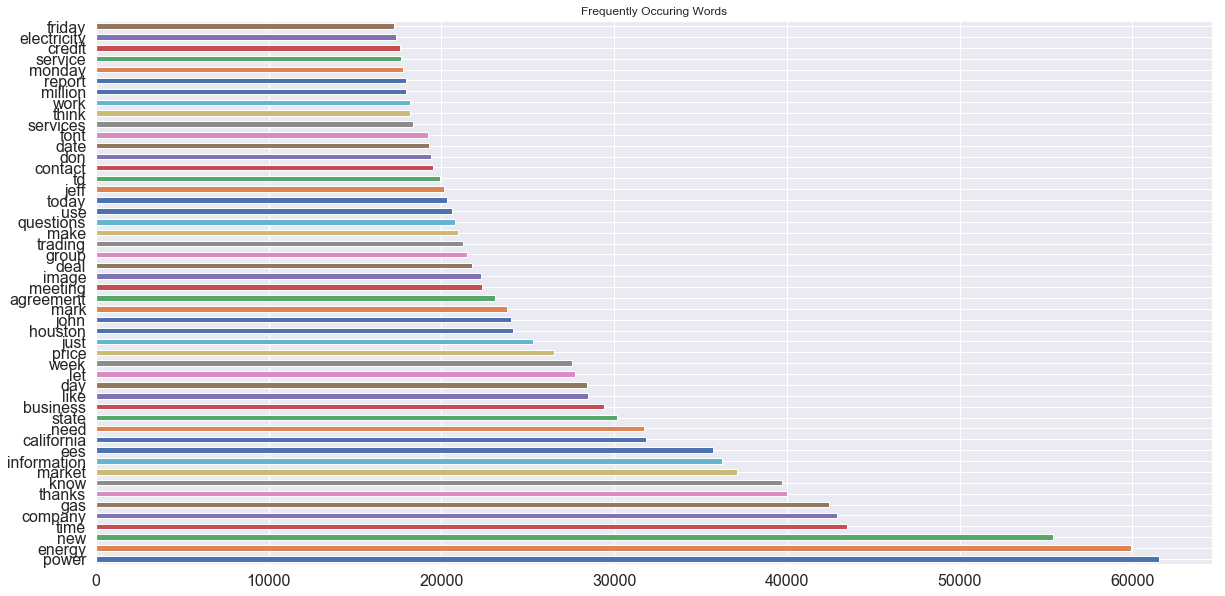

In [190]:
X_df.sum().sort_values(ascending=False).head(50).plot(kind='barh',
                                                                  figsize=(20,10),
                                                                  fontsize=16,
                                                                  title='Frequently Occuring Words');

In [194]:
X_df.sum().sort_values(ascending=False).head(50).to_frame()

,0
power,61521
energy,59937
new,55393
time,43476
company,42883
gas,42459
thanks,40003
know,39739
market,37091
information,36272


## Feature Words Per Cluster

In [176]:
for i in range(true_k):
     print('Cluster d:', i),
     for ind in order_centroids[i, :20]:
         print(' ', terms[ind])

Cluster d: 0
  businesses
  option
  defense
  manager
  linda
  evening
  known
  assignment
  attend
  analysis
  season
  crude
  hot
  sellers
  business
  efforts
  debbie
  students
  charge
  dale
Cluster d: 1
  sources
  engine
  stories
  role
  applications
  30
  body
  trades
  quickly
  75
  doug
  south
  follow
  site
  annual
  computer
  person
  light
  break
  alternative
Cluster d: 2
  manager
  stake
  station
  including
  defense
  option
  day
  gov
  evening
  main
  known
  investigation
  involved
  commodity
  businesses
  tools
  holding
  assignment
  hub
  knowledge
Cluster d: 3
  meter
  bpa
  impacted
  quantity
  heat
  software
  assistance
  mkt_type
  ancillary
  appear
  option
  members
  shapiro
  kenneth
  industry
  sense
  holding
  read
  judy
  dear
Cluster d: 4
  option
  season
  defense
  attend
  debbie
  commodities
  evening
  team
  pager
  page
  notice
  analysis
  dave
  red
  manager
  known
  clean
  teams
  brown
  office


## Run Test Document & Find it's Cluster

In [177]:
# confirming we still have our 'body' document
test_document = df['content'][0]
test_document

'Outstanding issues (created by Mary Hain/HOU/ECT on 10/21/98)'

In [178]:
# test_X_dense
# X_df = X_df.drop(X_df.iloc[:, 0:79], axis = 1)

In [179]:
test_X = cv.transform([test_document])
test_X_dense = test_X.todense()

In [180]:
text_X_df = pd.DataFrame(test_X_dense, columns=cv.get_feature_names())
# creating new dense to correct for chopped of features earlier

In [181]:
text_X_df = text_X_df.iloc[:,106:]

In [182]:
text_X_df.head(5)

,ability,able,accept,access,according,account,accounting,accounts,acquisition,act,action,actions,active,activities,activity,actual,actually,adams,add,added,addition,additional,address,addressed,administration,administrative,advance,advantage,advice,advise,aep,affairs,affiliate,affiliates,afternoon,agency,agenda,agent,ago,agree,agreed,agreement,agreements,ahead,air,airlines,airport,al,alan,alert,alias,align,allen,allow,allowed,alternative,amendment,america,american,amy,analysis,analyst,analysts,ancillary,andersen,anderson,andrea,andrew,andy,angeles,ann,announce,announced,announcement,annual,answer,aol,ap,appear,appears,applicable,application,applications,apply,appreciate,approach,appropriate,approval,approve,approved,approximately,april,area,areas,arial,arnold,article,asap,ask,asked,asking,assembly,asset,assets,assignment,assist,assistance,assistant,associate,associated,associates,association,assume,attachment,attachments,attempting,attend,attention,attorney,auction,august,austin,authority,authorized,availability,available,average,avoid,awarded,aware,away,azurix,backout,bad,balance,bandwidth,bank,bankruptcy,banks,barbara,barry,base,based,basis,bass,bay,beach,beck,began,begin,beginning,behalf,belden,believe,ben,benefit,benefits,berkeley,best,beth,better,bgcolor,bid,bids,big,biggest,billion,bills,bit,black,blackouts,bloomberg,blue,board,bob,body,bond,bonds,book,books,border,borland,boston,bought,box,boyd,bp,bpa,br,bracepatt,brad,bradford,break,brenda,brent,brian,brief,bring,broadband,broker,brought,brown,browser,bruce,bryan,budget,build,building,built,bush,business,businesses,busy,button,buy,buyer,buying,ca,caiso,cal,calendar,calif,california,called,calling,calls,calpine,came,campaign,campbell,canada,canadian,cap,capacity,capital,caps,car,card,care,carol,carolyn,case,cases,cash,cause,cell,cellpadding,cellspacing,center,central,...,strong,structure,students,study,stuff,style,submit,submitted,subscribe,subscription,success,successful,sue,suggest,suggested,suggestions,suite,summary,summer,sun,sunday,suppliers,supplies,supply,support,sure,survey,susan,suzanne,swap,swaps,symes,systems,table,taken,takes,taking,talk,talked,talking,talks,tamara,tana,tanya,target,tariff,task,tax,taxes,taylor,td,td2,te,team,teams,tech,technical,technologies,technology,ted,tel,telephone,tell,term,termination,terms,test,testing,texas,text,th,thank,thanks,thing,things,think,thinking,thomas,thompson,thought,thoughts,thursday,ticket,tickets,tim,time,times,title,today,todd,told,tom,tomorrow,tonight,tony,took,tools,total,touch,town,tr,track,tracy,trade,traded,trader,traders,trades,trading,training,trans_date,trans_type,transaction,transactions,transfer,transition,transmission,transport,transportation,transwestern,travel,trip,true,trust,try,trying,tuesday,turbine,turn,tw,tx,txt,type,types,ubs,uk,unable,understand,understanding,unify,union,unit,united,units,university,unknown,unless,unsubscribe,update,updated,updates,url,usa,use,used,user,users,using,ut,utilities,utility,vacation,valley,value,var,variances,various,ve,venture,ventures,version,vice,video,view,vince,visit,voice,volatility,volume,volumes,vote,vp,vs,wa,wait,waiting,wall,want,wanted,wants,ward,washington,watch,water,watson,way,ways,weather,web,website,wed,wednesday,week,weekend,weekly,weeks,welcome,went,west,western,white,wholesale,wide,width,william,williams,willing,wilson,win,wind,winter,wire,wireless,wish,won,wood,word,words,work,worked,working,works,world,worth,wr,write,writing,written,wrong,wrote,www,xls,yahoo,yards,years,yes,yesterday,york,young,zone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [183]:
print('Prediction')
predicted = model.predict(text_X_df)
print(predicted)

Prediction
[2]


## Plot Clusters

In [184]:
# centers[:, 0]

In [185]:
model.cluster_centers_.shape

(5, 1894)

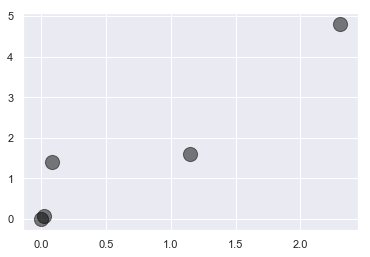

In [186]:

centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

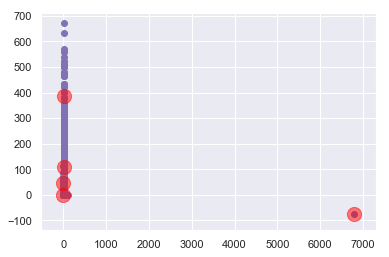

In [187]:
pca = PCA(n_components=2)
coords = pca.fit_transform(X_df)

centers = model.cluster_centers_
pca_centers = pca.transform(centers)

plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', s=200, alpha=0.5)
plt.show()

In [188]:
pca.transform(model.cluster_centers_)

array([[ 3.58276565e+00,  1.09256110e+02],
       [ 8.27720474e-01,  4.63638656e+01],
       [-8.56229854e-02, -6.31951141e-01],
       [ 6.79796865e+03, -7.32437158e+01],
       [ 1.10017627e+01,  3.85172244e+02]])

## Preparing Data For Visualization

In [101]:
X_df.shape

(103246, 1894)

In [102]:
X_df.tail()

,ability,able,accept,access,according,account,accounting,accounts,acquisition,act,action,actions,active,activities,activity,actual,actually,adams,add,added,addition,additional,address,addressed,administration,administrative,advance,advantage,advice,advise,aep,affairs,affiliate,affiliates,afternoon,agency,agenda,agent,ago,agree,agreed,agreement,agreements,ahead,air,airlines,airport,al,alan,alert,alias,align,allen,allow,allowed,alternative,amendment,america,american,amy,analysis,analyst,analysts,ancillary,andersen,anderson,andrea,andrew,andy,angeles,ann,announce,announced,announcement,annual,answer,aol,ap,appear,appears,applicable,application,applications,apply,appreciate,approach,appropriate,approval,approve,approved,approximately,april,area,areas,arial,arnold,article,asap,ask,asked,asking,assembly,asset,assets,assignment,assist,assistance,assistant,associate,associated,associates,association,assume,attachment,attachments,attempting,attend,attention,attorney,auction,august,austin,authority,authorized,availability,available,average,avoid,awarded,aware,away,azurix,backout,bad,balance,bandwidth,bank,bankruptcy,banks,barbara,barry,base,based,basis,bass,bay,beach,beck,began,begin,beginning,behalf,belden,believe,ben,benefit,benefits,berkeley,best,beth,better,bgcolor,bid,bids,big,biggest,billion,bills,bit,black,blackouts,bloomberg,blue,board,bob,body,bond,bonds,book,books,border,borland,boston,bought,box,boyd,bp,bpa,br,bracepatt,brad,bradford,break,brenda,brent,brian,brief,bring,broadband,broker,brought,brown,browser,bruce,bryan,budget,build,building,built,bush,business,businesses,busy,button,buy,buyer,buying,ca,caiso,cal,calendar,calif,california,called,calling,calls,calpine,came,campaign,campbell,canada,canadian,cap,capacity,capital,caps,car,card,care,carol,carolyn,case,cases,cash,cause,cell,cellpadding,cellspacing,center,central,...,structure,students,study,stuff,style,submit,submitted,subscribe,subscription,success,successful,sue,suggest,suggested,suggestions,suite,summary,summer,sun,sunday,suppliers,supplies,supply,support,sure,survey,susan,suzanne,swap,swaps,symes,systems,table,taken,takes,taking,talk,talked,talking,talks,tamara,tana,tanya,target,tariff,task,tax,taxes,taylor,td,td2,te,team,teams,tech,technical,technologies,technology,ted,tel,telephone,tell,term,termination,terms,test,testing,texas,text,th,thank,thanks,thing,things,think,thinking,thomas,thompson,thought,thoughts,thursday,ticket,tickets,tim,time,times,title,today,todd,told,tom,tomorrow,tonight,tony,took,tools,total,touch,town,tr,track,tracy,trade,traded,trader,traders,trades,trading,training,trans_date,trans_type,transaction,transactions,transfer,transition,transmission,transport,transportation,transwestern,travel,trip,true,trust,try,trying,tuesday,turbine,turn,tw,tx,txt,type,types,ubs,uk,unable,understand,understanding,unify,union,unit,united,units,university,unknown,unless,unsubscribe,update,updated,updates,url,usa,use,used,user,users,using,ut,utilities,utility,vacation,valley,value,var,variances,various,ve,venture,ventures,version,vice,video,view,vince,visit,voice,volatility,volume,volumes,vote,vp,vs,wa,wait,waiting,wall,want,wanted,wants,ward,washington,watch,water,watson,way,ways,weather,web,website,wed,wednesday,week,weekend,weekly,weeks,welcome,went,west,western,white,wholesale,wide,width,william,williams,willing,wilson,win,wind,winter,wire,wireless,wish,won,wood,word,words,work,worked,working,works,world,worth,wr,write,writing,written,wrong,wrote,www,xls,yahoo,yards,year,years,yes,yesterday,york,young,zone
103241,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [103]:
df.shape

(103246, 2)

In [104]:
df.tail()

,Date,content
103241,2004-02-04 02:14:47,$ * $ * $ * $ * HOTWEBCASH * $ * $ * $ * $ Fin...
103242,2004-02-04 02:14:47,$ * $ * $ * $ * HOTWEBCASH * $ * $ * $ * $ I j...
103243,2004-02-04 02:14:47,$ * $ * $ * $ * HOTWEBCASH * $ * $ * $ * $ Par...
103244,2004-02-04 02:23:50,============================ PRO FOOTBALL EXTR...
103245,2004-02-04 02:41:50,"If you are seeing this message, your email cli..."


In [105]:
X_df.shape # features

(103246, 1894)

- concatanate these two data frames
- group by top 50 words per day
- group by top 50 words
- group by day

### Concatinating/Merging Two Data Frames

In [132]:
merged_df = pd.merge(df, X_df, left_index=True, right_index=True)

In [133]:
merged_df.shape

(103246, 1896)

In [134]:
merged_df.tail()

,Date,content_x,ability,able,accept,access,according,account,accounting,accounts,acquisition,act,action,actions,active,activities,activity,actual,actually,adams,add,added,addition,additional,address,addressed,administration,administrative,advance,advantage,advice,advise,aep,affairs,affiliate,affiliates,afternoon,agency,agenda,agent,ago,agree,agreed,agreement,agreements,ahead,air,airlines,airport,al,alan,alert,alias,align,allen,allow,allowed,alternative,amendment,america,american,amy,analysis,analyst,analysts,ancillary,andersen,anderson,andrea,andrew,andy,angeles,ann,announce,announced,announcement,annual,answer,aol,ap,appear,appears,applicable,application,applications,apply,appreciate,approach,appropriate,approval,approve,approved,approximately,april,area,areas,arial,arnold,article,asap,ask,asked,asking,assembly,asset,assets,assignment,assist,assistance,assistant,associate,associated,associates,association,assume,attachment,attachments,attempting,attend,attention,attorney,auction,august,austin,authority,authorized,availability,available,average,avoid,awarded,aware,away,azurix,backout,bad,balance,bandwidth,bank,bankruptcy,banks,barbara,barry,base,based,basis,bass,bay,beach,beck,began,begin,beginning,behalf,belden,believe,ben,benefit,benefits,berkeley,best,beth,better,bgcolor,bid,bids,big,biggest,billion,bills,bit,black,blackouts,bloomberg,blue,board,bob,body,bond,bonds,book,books,border,borland,boston,bought,box,boyd,bp,bpa,br,bracepatt,brad,bradford,break,brenda,brent,brian,brief,bring,broadband,broker,brought,brown,browser,bruce,bryan,budget,build,building,built,bush,business,businesses,busy,button,buy,buyer,buying,ca,caiso,cal,calendar,calif,california,called,calling,calls,calpine,came,campaign,campbell,canada,canadian,cap,capacity,capital,caps,car,card,care,carol,carolyn,case,cases,cash,cause,cell,cellpadding,cellspacing,...,structure,students,study,stuff,style,submit,submitted,subscribe,subscription,success,successful,sue,suggest,suggested,suggestions,suite,summary,summer,sun,sunday,suppliers,supplies,supply,support,sure,survey,susan,suzanne,swap,swaps,symes,systems,table,taken,takes,taking,talk,talked,talking,talks,tamara,tana,tanya,target,tariff,task,tax,taxes,taylor,td,td2,te,team,teams,tech,technical,technologies,technology,ted,tel,telephone,tell,term,termination,terms,test,testing,texas,text,th,thank,thanks,thing,things,think,thinking,thomas,thompson,thought,thoughts,thursday,ticket,tickets,tim,time,times,title,today,todd,told,tom,tomorrow,tonight,tony,took,tools,total,touch,town,tr,track,tracy,trade,traded,trader,traders,trades,trading,training,trans_date,trans_type,transaction,transactions,transfer,transition,transmission,transport,transportation,transwestern,travel,trip,true,trust,try,trying,tuesday,turbine,turn,tw,tx,txt,type,types,ubs,uk,unable,understand,understanding,unify,union,unit,united,units,university,unknown,unless,unsubscribe,update,updated,updates,url,usa,use,used,user,users,using,ut,utilities,utility,vacation,valley,value,var,variances,various,ve,venture,ventures,version,vice,video,view,vince,visit,voice,volatility,volume,volumes,vote,vp,vs,wa,wait,waiting,wall,want,wanted,wants,ward,washington,watch,water,watson,way,ways,weather,web,website,wed,wednesday,week,weekend,weekly,weeks,welcome,went,west,western,white,wholesale,wide,width,william,williams,willing,wilson,win,wind,winter,wire,wireless,wish,won,wood,word,words,work,worked,working,works,world,worth,wr,write,writing,written,wrong,wrote,www,xls,yahoo,yards,year,years,yes,yesterday,york,young,zone
103241,2004-02-04 02:14:47,$ * $ * $ * $ * HOTWEBCASH * $ * $ * $ * $ Fin...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [135]:
merged_df.dtypes

Date         datetime64[ns]
content_x            object
ability               int64
able                  int64
accept                int64
access                int64
according             int64
                  ...      
year                  int64
years                 int64
yes                   int64
yesterday             int64
york                  int64
young                 int64
zone                  int64
Length: 1896, dtype: object

In [136]:
merged_df.shape

(103246, 1896)

In [137]:
merged_df

,Date,content_x,ability,able,accept,access,according,account,accounting,accounts,acquisition,act,action,actions,active,activities,activity,actual,actually,adams,add,added,addition,additional,address,addressed,administration,administrative,advance,advantage,advice,advise,aep,affairs,affiliate,affiliates,afternoon,agency,agenda,agent,ago,agree,agreed,agreement,agreements,ahead,air,airlines,airport,al,alan,alert,alias,align,allen,allow,allowed,alternative,amendment,america,american,amy,analysis,analyst,analysts,ancillary,andersen,anderson,andrea,andrew,andy,angeles,ann,announce,announced,announcement,annual,answer,aol,ap,appear,appears,applicable,application,applications,apply,appreciate,approach,appropriate,approval,approve,approved,approximately,april,area,areas,arial,arnold,article,asap,ask,asked,asking,assembly,asset,assets,assignment,assist,assistance,assistant,associate,associated,associates,association,assume,attachment,attachments,attempting,attend,attention,attorney,auction,august,austin,authority,authorized,availability,available,average,avoid,awarded,aware,away,azurix,backout,bad,balance,bandwidth,bank,bankruptcy,banks,barbara,barry,base,based,basis,bass,bay,beach,beck,began,begin,beginning,behalf,belden,believe,ben,benefit,benefits,berkeley,best,beth,better,bgcolor,bid,bids,big,biggest,billion,bills,bit,black,blackouts,bloomberg,blue,board,bob,body,bond,bonds,book,books,border,borland,boston,bought,box,boyd,bp,bpa,br,bracepatt,brad,bradford,break,brenda,brent,brian,brief,bring,broadband,broker,brought,brown,browser,bruce,bryan,budget,build,building,built,bush,business,businesses,busy,button,buy,buyer,buying,ca,caiso,cal,calendar,calif,california,called,calling,calls,calpine,came,campaign,campbell,canada,canadian,cap,capacity,capital,caps,car,card,care,carol,carolyn,case,cases,cash,cause,cell,cellpadding,cellspacing,...,structure,students,study,stuff,style,submit,submitted,subscribe,subscription,success,successful,sue,suggest,suggested,suggestions,suite,summary,summer,sun,sunday,suppliers,supplies,supply,support,sure,survey,susan,suzanne,swap,swaps,symes,systems,table,taken,takes,taking,talk,talked,talking,talks,tamara,tana,tanya,target,tariff,task,tax,taxes,taylor,td,td2,te,team,teams,tech,technical,technologies,technology,ted,tel,telephone,tell,term,termination,terms,test,testing,texas,text,th,thank,thanks,thing,things,think,thinking,thomas,thompson,thought,thoughts,thursday,ticket,tickets,tim,time,times,title,today,todd,told,tom,tomorrow,tonight,tony,took,tools,total,touch,town,tr,track,tracy,trade,traded,trader,traders,trades,trading,training,trans_date,trans_type,transaction,transactions,transfer,transition,transmission,transport,transportation,transwestern,travel,trip,true,trust,try,trying,tuesday,turbine,turn,tw,tx,txt,type,types,ubs,uk,unable,understand,understanding,unify,union,unit,united,units,university,unknown,unless,unsubscribe,update,updated,updates,url,usa,use,used,user,users,using,ut,utilities,utility,vacation,valley,value,var,variances,various,ve,venture,ventures,version,vice,video,view,vince,visit,voice,volatility,volume,volumes,vote,vp,vs,wa,wait,waiting,wall,want,wanted,wants,ward,washington,watch,water,watson,way,ways,weather,web,website,wed,wednesday,week,weekend,weekly,weeks,welcome,went,west,western,white,wholesale,wide,width,william,williams,willing,wilson,win,wind,winter,wire,wireless,wish,won,wood,word,words,work,worked,working,works,world,worth,wr,write,writing,written,wrong,wrote,www,xls,yahoo,yards,year,years,yes,yesterday,york,young,zone
0,1980-01-01 00:00:00,Outstanding issues (created by Mary Hain/HOU/E...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [138]:
merged_df_date = merged_df.resample('D', on = 'Date').sum()

In [139]:
merged_df_date.head()

,ability,able,accept,access,according,account,accounting,accounts,acquisition,act,action,actions,active,activities,activity,actual,actually,adams,add,added,addition,additional,address,addressed,administration,administrative,advance,advantage,advice,advise,aep,affairs,affiliate,affiliates,afternoon,agency,agenda,agent,ago,agree,agreed,agreement,agreements,ahead,air,airlines,airport,al,alan,alert,alias,align,allen,allow,allowed,alternative,amendment,america,american,amy,analysis,analyst,analysts,ancillary,andersen,anderson,andrea,andrew,andy,angeles,ann,announce,announced,announcement,annual,answer,aol,ap,appear,appears,applicable,application,applications,apply,appreciate,approach,appropriate,approval,approve,approved,approximately,april,area,areas,arial,arnold,article,asap,ask,asked,asking,assembly,asset,assets,assignment,assist,assistance,assistant,associate,associated,associates,association,assume,attachment,attachments,attempting,attend,attention,attorney,auction,august,austin,authority,authorized,availability,available,average,avoid,awarded,aware,away,azurix,backout,bad,balance,bandwidth,bank,bankruptcy,banks,barbara,barry,base,based,basis,bass,bay,beach,beck,began,begin,beginning,behalf,belden,believe,ben,benefit,benefits,berkeley,best,beth,better,bgcolor,bid,bids,big,biggest,billion,bills,bit,black,blackouts,bloomberg,blue,board,bob,body,bond,bonds,book,books,border,borland,boston,bought,box,boyd,bp,bpa,br,bracepatt,brad,bradford,break,brenda,brent,brian,brief,bring,broadband,broker,brought,brown,browser,bruce,bryan,budget,build,building,built,bush,business,businesses,busy,button,buy,buyer,buying,ca,caiso,cal,calendar,calif,california,called,calling,calls,calpine,came,campaign,campbell,canada,canadian,cap,capacity,capital,caps,car,card,care,carol,carolyn,case,cases,cash,cause,cell,cellpadding,cellspacing,center,central,...,structure,students,study,stuff,style,submit,submitted,subscribe,subscription,success,successful,sue,suggest,suggested,suggestions,suite,summary,summer,sun,sunday,suppliers,supplies,supply,support,sure,survey,susan,suzanne,swap,swaps,symes,systems,table,taken,takes,taking,talk,talked,talking,talks,tamara,tana,tanya,target,tariff,task,tax,taxes,taylor,td,td2,te,team,teams,tech,technical,technologies,technology,ted,tel,telephone,tell,term,termination,terms,test,testing,texas,text,th,thank,thanks,thing,things,think,thinking,thomas,thompson,thought,thoughts,thursday,ticket,tickets,tim,time,times,title,today,todd,told,tom,tomorrow,tonight,tony,took,tools,total,touch,town,tr,track,tracy,trade,traded,trader,traders,trades,trading,training,trans_date,trans_type,transaction,transactions,transfer,transition,transmission,transport,transportation,transwestern,travel,trip,true,trust,try,trying,tuesday,turbine,turn,tw,tx,txt,type,types,ubs,uk,unable,understand,understanding,unify,union,unit,united,units,university,unknown,unless,unsubscribe,update,updated,updates,url,usa,use,used,user,users,using,ut,utilities,utility,vacation,valley,value,var,variances,various,ve,venture,ventures,version,vice,video,view,vince,visit,voice,volatility,volume,volumes,vote,vp,vs,wa,wait,waiting,wall,want,wanted,wants,ward,washington,watch,water,watson,way,ways,weather,web,website,wed,wednesday,week,weekend,weekly,weeks,welcome,went,west,western,white,wholesale,wide,width,william,williams,willing,wilson,win,wind,winter,wire,wireless,wish,won,wood,word,words,work,worked,working,works,world,worth,wr,write,writing,written,wrong,wrote,www,xls,yahoo,yards,year,years,yes,yesterday,york,young,zone
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [146]:
merged_df_date = merged_df_date.reset_index()

In [149]:
merged_df_date.dtypes

Date         datetime64[ns]
ability               int64
able                  int64
accept                int64
access                int64
according             int64
account               int64
                  ...      
year                  int64
years                 int64
yes                   int64
yesterday             int64
york                  int64
young                 int64
zone                  int64
Length: 1895, dtype: object

In [153]:
merged_df_date.head()

,Date,ability,able,accept,access,according,account,accounting,accounts,acquisition,act,action,actions,active,activities,activity,actual,actually,adams,add,added,addition,additional,address,addressed,administration,administrative,advance,advantage,advice,advise,aep,affairs,affiliate,affiliates,afternoon,agency,agenda,agent,ago,agree,agreed,agreement,agreements,ahead,air,airlines,airport,al,alan,alert,alias,align,allen,allow,allowed,alternative,amendment,america,american,amy,analysis,analyst,analysts,ancillary,andersen,anderson,andrea,andrew,andy,angeles,ann,announce,announced,announcement,annual,answer,aol,ap,appear,appears,applicable,application,applications,apply,appreciate,approach,appropriate,approval,approve,approved,approximately,april,area,areas,arial,arnold,article,asap,ask,asked,asking,assembly,asset,assets,assignment,assist,assistance,assistant,associate,associated,associates,association,assume,attachment,attachments,attempting,attend,attention,attorney,auction,august,austin,authority,authorized,availability,available,average,avoid,awarded,aware,away,azurix,backout,bad,balance,bandwidth,bank,bankruptcy,banks,barbara,barry,base,based,basis,bass,bay,beach,beck,began,begin,beginning,behalf,belden,believe,ben,benefit,benefits,berkeley,best,beth,better,bgcolor,bid,bids,big,biggest,billion,bills,bit,black,blackouts,bloomberg,blue,board,bob,body,bond,bonds,book,books,border,borland,boston,bought,box,boyd,bp,bpa,br,bracepatt,brad,bradford,break,brenda,brent,brian,brief,bring,broadband,broker,brought,brown,browser,bruce,bryan,budget,build,building,built,bush,business,businesses,busy,button,buy,buyer,buying,ca,caiso,cal,calendar,calif,california,called,calling,calls,calpine,came,campaign,campbell,canada,canadian,cap,capacity,capital,caps,car,card,care,carol,carolyn,case,cases,cash,cause,cell,cellpadding,cellspacing,center,...,structure,students,study,stuff,style,submit,submitted,subscribe,subscription,success,successful,sue,suggest,suggested,suggestions,suite,summary,summer,sun,sunday,suppliers,supplies,supply,support,sure,survey,susan,suzanne,swap,swaps,symes,systems,table,taken,takes,taking,talk,talked,talking,talks,tamara,tana,tanya,target,tariff,task,tax,taxes,taylor,td,td2,te,team,teams,tech,technical,technologies,technology,ted,tel,telephone,tell,term,termination,terms,test,testing,texas,text,th,thank,thanks,thing,things,think,thinking,thomas,thompson,thought,thoughts,thursday,ticket,tickets,tim,time,times,title,today,todd,told,tom,tomorrow,tonight,tony,took,tools,total,touch,town,tr,track,tracy,trade,traded,trader,traders,trades,trading,training,trans_date,trans_type,transaction,transactions,transfer,transition,transmission,transport,transportation,transwestern,travel,trip,true,trust,try,trying,tuesday,turbine,turn,tw,tx,txt,type,types,ubs,uk,unable,understand,understanding,unify,union,unit,united,units,university,unknown,unless,unsubscribe,update,updated,updates,url,usa,use,used,user,users,using,ut,utilities,utility,vacation,valley,value,var,variances,various,ve,venture,ventures,version,vice,video,view,vince,visit,voice,volatility,volume,volumes,vote,vp,vs,wa,wait,waiting,wall,want,wanted,wants,ward,washington,watch,water,watson,way,ways,weather,web,website,wed,wednesday,week,weekend,weekly,weeks,welcome,went,west,western,white,wholesale,wide,width,william,williams,willing,wilson,win,wind,winter,wire,wireless,wish,won,wood,word,words,work,worked,working,works,world,worth,wr,write,writing,written,wrong,wrote,www,xls,yahoo,yards,year,years,yes,yesterday,york,young,zone
0,1980-01-01,2,6,3,38,1,1,0,3,0,0,25,3,0,3,8,1,0,0,2,3,0,15,7,0,6,0,0,0,4,0,0,7,0,3,1,6,12,0,0,1,2,21,2,4,12,3,0,6,33,4,0,0,7,2,0,0,3,6,0,0,24,7,0,0,3,0,0,2,0,0,9,9,3,3,2,2,2,3,3,6,0,2,10,0,1,0,4,4,1,2,0,8,4,0,0,1,9,0,3,7,0,9,0,13,9,3,0,1,0,4,1,0,0,7,4,0,0,3,15,18,2,4,1,1,0,3,6,4,0,1,3,2,0,7,1,2,0,23,3,0,3,1,6,1,0,0,0,3,0,1,4,1,3,2,3,2,4,6,2,1,3,0,1,0,5,0,3,2,0,3,9,0,1,8,0,0,0,3,7,3,3,0,0,2,2,4,4,0,0,0,1,9,0,0,0,4,15,3,3,0,1,1,0,0,0,3,3,3,0,11,13,5,0,5,21,1

In [151]:
merged_df_date.to_csv('./data/merged_df_date.csv', index=False)